In [218]:
def extract_loc_ts_from_gpx(gpx_file_path):
    import xmltodict
    with open(gpx_file_path) as f:
        doc = xmltodict.parse(f.read())['gpx']['trk']
        raw_path = doc['link']['@href']
        vid_name = raw_path[raw_path.rfind('\\')+1:]

        locations = []
        tss = []
        for seg in doc['trkseg']['trkpt']:
            lat = float(seg['@lat'])
            lon = float(seg['@lon'])
            loc = (lon,lat)
            ts = seg['time']
            locations.append(loc)
            tss.append(ts)
        # TODO: what does this length means
        length = doc['extensions']['gpxtrkx:TrackStatsExtension']['gpxtrkx:TotalElapsedTime']
    return locations, tss

gpx_file = 'Sample Data/Track_2015-10-15 060649.gpx'

locations, tss = extract_loc_ts_from_gpx(gpx_file)

# new_gps_nts, confidences_nts = snap2road(locations,return_confidence=True)
# new_gps = snap2road(locations, tss)

In [1]:
# right align locations and timestamp with duration
times = range(length+1)
times_size = len(times)
points_size = len(locations)
diff = times_size-points_size
for _ in range(diff):
    locations.insert(0, None)
    tss.insert(0, None)

NameError: name 'length' is not defined

In [222]:
zip(times, locations, tss)

[(0, None, None),
 (1, None, None),
 (2, (-76.935399184, 38.9834857453), u'2015-10-15T12:06:50Z'),
 (3, (-76.935399184, 38.9834857453), u'2015-10-15T12:06:51Z'),
 (4, (-76.935399184, 38.9834857453), u'2015-10-15T12:06:52Z'),
 (5, (-76.935399184, 38.9834857453), u'2015-10-15T12:06:53Z'),
 (6, (-76.935399184, 38.9834857453), u'2015-10-15T12:06:54Z'),
 (7, (-76.935399184, 38.9834857453), u'2015-10-15T12:06:55Z'),
 (8, (-76.935399184, 38.9834857453), u'2015-10-15T12:06:56Z'),
 (9, (-76.935399184, 38.9834857453), u'2015-10-15T12:06:57Z'),
 (10, (-76.935399184, 38.9834857453), u'2015-10-15T12:06:58Z'),
 (11, (-76.935399184, 38.9834857453), u'2015-10-15T12:06:59Z'),
 (12, (-76.935399184, 38.9834857453), u'2015-10-15T12:07:00Z'),
 (13, (-76.935399184, 38.9834857453), u'2015-10-15T12:07:01Z'),
 (14, (-76.935399184, 38.9834857453), u'2015-10-15T12:07:02Z'),
 (15, (-76.935399184, 38.9834857453), u'2015-10-15T12:07:03Z'),
 (16, (-76.935399184, 38.9834857453), u'2015-10-15T12:07:04Z'),
 (17, (-76.9

In [238]:
for sub in chunks(zip(times, locations, tss)[:161], 40, right_close=True):
    print sub

[(0, None, None), (1, None, None), (2, (-76.935399184, 38.9834857453), u'2015-10-15T12:06:50Z'), (3, (-76.935399184, 38.9834857453), u'2015-10-15T12:06:51Z'), (4, (-76.935399184, 38.9834857453), u'2015-10-15T12:06:52Z'), (5, (-76.935399184, 38.9834857453), u'2015-10-15T12:06:53Z'), (6, (-76.935399184, 38.9834857453), u'2015-10-15T12:06:54Z'), (7, (-76.935399184, 38.9834857453), u'2015-10-15T12:06:55Z'), (8, (-76.935399184, 38.9834857453), u'2015-10-15T12:06:56Z'), (9, (-76.935399184, 38.9834857453), u'2015-10-15T12:06:57Z'), (10, (-76.935399184, 38.9834857453), u'2015-10-15T12:06:58Z'), (11, (-76.935399184, 38.9834857453), u'2015-10-15T12:06:59Z'), (12, (-76.935399184, 38.9834857453), u'2015-10-15T12:07:00Z'), (13, (-76.935399184, 38.9834857453), u'2015-10-15T12:07:01Z'), (14, (-76.935399184, 38.9834857453), u'2015-10-15T12:07:02Z'), (15, (-76.935399184, 38.9834857453), u'2015-10-15T12:07:03Z'), (16, (-76.935399184, 38.9834857453), u'2015-10-15T12:07:04Z'), (17, (-76.9354084879, 38.983

In [ ]:
# TODO: replace split loop in split.py with this chunk function

## Note about GPX 
1. how coords correspond to video timelnie
    - 0s(start recording) --> no point
    - 1s(after 1 second) --> no point
    - 2s(2 full seconds past) --> No. 1 point (record the first point)
    - 23s --> No. 22 point
    - 164s(the final full second) --> No. 163 point(the final point)
    - 164.1 (when video stops) --> no point
    - it doesn't record the point where recording just started
2. use index of point instead of time difference to match coords and video timeline (because the sample video shows that the timestamp of beginning of the trace could be seriously wrong)


In [1]:
import mapbox as mp
import pandas as pd
import geopandas as gp
import math
import time
from shapely.geometry import Point, LineString
%matplotlib inline

In [2]:
from qgrid import show_grid

In [234]:
def float_round(num, places = 1, direction = 'up'):
    from math import ceil, floor
    assert direction in ['up', 'down'], 'direction options are: up and down'
    func = {'up': ceil, 'down': floor}[direction]
    return func(num * (10**places)) / float(10**places)


def even_chunks(array, max_chunk_size, indices=False):
    import math
    size = len(array)
    num_chunks = math.ceil(size*1.0/max_chunk_size)
    new_chunk_size = int(math.ceil(size*1.0 / num_chunks))
    return chunks(array, new_chunk_size,indices)

def chunks(array, chunk_size, indices=False, right_close=False):
    """Yield successive chunks with chunk_size from array.
    params:
        indices: if false, yield chunks of array; if True, yield indices pair (left, right) only
        right_close: if False return elements with indices in [left, right); if True, return indices in [left, right]
    """
    for i in range(0, len(array), chunk_size):
        left = i
        right = min(len(array), i + chunk_size + right_close)  
        if indices:
            yield (left, right)
        else:
            yield array[left: right]

In [4]:
def snap2road(pts_lon_lat, timestamps=[], return_confidence=False):
    """
    params:
        pts_lon_lat: [[lon, lat], [], ...]
        timestamps: ['2015-10-15T12:06:50Z', ...]
    return: 
        new_gps: [[lon, lat], [], ...], len(new_gps) not necessarily equals to len(pts_lon_lat)
        confidences: [ (which batch, # origin pts, # snapped pts, confidence), (), ..]
    """
    import mapbox as mp
    access = "pk.eyJ1Ijoic3VyYWpuYWlyIiwiYSI6ImNpdWoyZGQzYjAwMXkyb285b2Q5NmV6amEifQ.WBQAX7ur2T3kOLyi11Nybw"
    service = mp.MapMatcher(access_token=access)
    new_gps = []
    confidences = []
    for num_batch, (s, e) in enumerate(even_chunks(pts_lon_lat, 100, indices=True)):
        batch_pts = pts_lon_lat[s:e]
        batch_tss = timestamps[s:e]
        geojson = {'type': 'Feature',
                   'properties': {'coordTimes': batch_tss},
                   'geometry': {'type': 'LineString',
                                'coordinates': batch_pts}}
        response = service.match(geojson, profile='mapbox.cycling')
        var = response.geojson()
        features = var['features']
        for f in features:
            coords = f['geometry']['coordinates']
            new_gps.extend(coords)
            properties = f['properties']
            if return_confidence:
                confidences.append((num_batch, len(batch_pts), len(coords), properties['confidence']))
    if return_confidence:
        return new_gps, confidences
    return new_gps

In [5]:

import geom_helper; reload(geom_helper)
from geom_helper import pts2segs

In [6]:
segs_dc = gp.read_file(u'd:\\★★学习工作\\Life in Maryland\\Research Project：CyclingSafe\\Cycling_safety\\open_data_analysis\\data\\segments_dc.geojson')

## Note for def seg_disambiguation:
1. if the first/last point of trace is on segmentA, but the rest are on segmentB, then the first point would be mistakenly assigned to segmentB. E.g. test_pts2segs3.geojson; 
    - solution: increase weights(multiple by window_size) to self seg_cands
        - Problem: window_size weights cause jump (test_pts2segs3[22:27])
            - solution: seconde phrase clean use a decrease weight factor=0.5
                - problem: still have jump (test_pts2segs3[22:26])
    - solution2: assign self seg_cands' weight with: window_size * 2 - len(context_left) - len(context_right) + 1
        - Problem: not good enough (test_pts2segs3[22:26] still jump)
            - enhance solution: use clean seg as left context
                - Problem: every point at intersection will be shifted to previous segment(especially when the last points are at intersection)            
2. timestamps helps: test_pts2segs5 is messy without timestamps.
3. random choice of tie seg isn't a good idea, because it's not garunteed that tie segs are one of the turning segs. e.g. test_pts2segs5 snapped.loc[137]
    - Solution: keep tie for the 1st phrase clean up --> it also solve the problem of intersection shifted
        - exception: test_pts2segs5 snapped.loc[83:87], because the orgn pts is messy
4. how to handle snapped points that match no segments(because we could be riding on roads that are not in the segment networks)
5. non-consecutive points will affect the linear reference. 
    - E.g. 
        - test_pts2segs5 on seg_idx=1127 and point_idx=[203,290] (doesn't affect the percentage result)
        - test_pts2segs5 on seg_idx=1175 and point_idx=[212,227] (double the percentage, from 0.5 to 1)
        - test_pts2segs5 on seg_idx=2384/2136 and point_idx=[262, 154]/[273, 165] (falsely increase from 0.8 to 1)
    - solution: 
        - calculate only consecutive points, consecutive is defined by cnsectv_stepsize(e.g. stepsize=3 means [1,2,5] are consecutive while [2,6] aren't)(this stepsize is to handle missing noise points), 
        - and the percentage of the segment should exceed cnsectv_thres(e.g. fraction of 0.05 of a segment is considered as noise)
    

In [7]:
def seg_disambiguation(list_of_seg_candidates, window_size=3, debug=False, decrease_weight=0.0, keep_tie=False):
    from itertools import chain
    from collections import Counter
    def debug_tie_count():
        max_count = counter.most_common(1)[0][1]
        tie_node = []
        for node, count in counter.most_common():
            if count>=max_count:
                tie_node.append(node)
        tie_count = len(tie_node)
        if tie_count==2: print i, counter
        assert tie_count<=3, ('index=',i, 'context_counter=', counter)
    
    def get_tie():
        max_count = counter.most_common(1)[0][1]
        tie_node = []
        for node, count in counter.most_common():
            if count>=max_count:
                tie_node.append(node)
        return tie_node
    
    clean_segs = []
    list_size = len(list_of_seg_candidates)
    for i, seg_cands in enumerate(list_of_seg_candidates):
        if len(seg_cands)==0:
            clean_segs.append([])
            continue
        left, right = max(0, i-window_size), min(list_size, i+window_size+1)
        context_left = clean_segs[left: i]  # use clean seg instead of original seg_candidates
        context_right = list_of_seg_candidates[i+1: right]
        counter_left = Counter(list(chain(*context_left)))
        counter_right = Counter(list(chain(*context_right)))
#         counter_self = Counter(seg_cands * int(window_size * (1-decrease_weight)))  # solution1, doesn't work well
        counter_self = Counter(seg_cands * (window_size * 2 - len(context_left) - len(context_right) + 1))
        counter = counter_left + counter_right + counter_self
        tie = get_tie()
        if keep_tie:
            seg = tie  # keep all tie
        else:
            seg = [tie[0]]  # keep the first element of tie
        clean_segs.append(seg)
        if debug:
            debug_tie_count()
    return clean_segs
#         print counter_left.most_common(1),counter_right.most_common(1),counter.most_common(1)

In [106]:
def consecutive(data, stepsize=1):
    import numpy as np
    return np.split(data, np.where(np.diff(data) > stepsize)[0]+1)
a =[0, 47, 48, 49, 50, 52, 97, 98, 99]
consecutive(a)

[array([0]), array([47, 48, 49, 50]), array([52]), array([97, 98, 99])]

In [107]:
np.diff(a)

array([47,  1,  1,  1,  2, 45,  1,  1])

In [112]:
def trace2segs(segs, trace_pts, tss=[], return_confidence=False, close_jn_dist=10, far_jn_dist=30, cnsectv_stepsize=3, cnsectv_thres=0.08):
    """
    
    """
    from itertools import chain
    pts_lon_lat = list(trace_pts.geometry.apply(lambda x: x.coords[0]).values)
    snap_pts = snap2road(pts_lon_lat,tss, return_confidence=return_confidence)

    if return_confidence:  # if return_confidence
        snap_pts, confs = snap_pts   
        print 'confidence of snap to road',confs

    snap_pts_gpdf = gp.GeoDataFrame([Point(x) for x in snap_pts],columns=['geometry'])
    

    pts_segs, _ = pts2segs(snap_pts_gpdf, segs, bfr_crs=3559, close_jn_dist=close_jn_dist, far_jn_dist=far_jn_dist)

    snap_pts_gpdf = snap_pts_gpdf.merge(
        snap_pts_gpdf.merge(pts_segs, left_index=True, right_on='index_pt').groupby('index_pt')['index_ln'].apply(list).to_frame(), 
        left_index=True, right_index=True)
    snap_pts_gpdf['clean_seg']=seg_disambiguation(snap_pts_gpdf.index_ln.values,keep_tie=True)

    snap_pts_gpdf['clean_seg2']=seg_disambiguation(snap_pts_gpdf.clean_seg.values)
    
    trace_segs_idx = pd.unique(chain(*snap_pts_gpdf.clean_seg2.values))
    segs_linear_reference = []
    for seg_index in trace_segs_idx:
        seg = segs_dc.loc[seg_index,'geometry']
        projected = snap_pts_gpdf[snap_pts_gpdf.index_ln.apply(lambda x: seg_index in x)].geometry.apply(lambda x: seg.project(x,normalized=True))
        for sub_indices in consecutive(projected.index.values, stepsize=cnsectv_stepsize):
            sub = projected[sub_indices]
            s, e = sub.min(), sub.max()
            round_s, round_e = float_round(s, direction='down'), float_round(e, direction='up')
            if e-s>cnsectv_thres:
                segs_linear_reference.append((seg_index, round_s, round_e, round_e - round_s))
    return segs_linear_reference

In [109]:
# facke timestamp
t = time.time()

In [113]:
# run def trace2segs
orgn_pts = gp.read_file('test_pts2segs5.geojson')
tss = [time.strftime('%Y-%m-%dT%H:%M:%SZ',time.gmtime(t+i*5)) for i in range(orgn_pts.shape[0])]
pts_lon_lat = list(orgn_pts.geometry.apply(lambda x: x.coords[0]).values)
segs_for_trace = trace2segs(segs_dc, pts_lon_lat, tss=tss, return_confidence=True)

segs_for_trace 
# for test_pts2segs1: correctly snap regardless the lon confidence
# for test_pts2segs2: seg 884 is the last seg with a few points, covered 10%
# for test_pts2segs3: seg 768 is the first seg with only one point, covered 20%
# for test_pts2segs4: seg 3209 is the last seg
# for test_pts2segs5: seg 2131 is the last seg
# for test_pts2segs6: seg 1052 is the first seg; but we should choose the route wisely, there are may small roads not covered by the segments



confidence of snap to road [(0, 68, 116, 0.8553247543617214), (1, 68, 100, 0.919279313449731), (2, 68, 91, 0.6664026680287239)]


[(2431, 0.0, 1.0, 1.0),
 (2432, 0.0, 1.0, 1.0),
 (2025, 0.0, 1.0, 1.0),
 (2026, 0.0, 1.0, 1.0),
 (2190, 0.0, 1.0, 1.0),
 (5257, 0.0, 1.0, 1.0),
 (5084, 0.0, 1.0, 1.0),
 (5083, 0.0, 1.0, 1.0),
 (5082, 0.0, 1.0, 1.0),
 (935, 0.0, 1.0, 1.0),
 (934, 0.0, 1.0, 1.0),
 (933, 0.0, 1.0, 1.0),
 (932, 0.0, 1.0, 1.0),
 (2430, 0.0, 1.0, 1.0),
 (1126, 0.0, 1.0, 1.0),
 (2133, 0.0, 1.0, 1.0),
 (2134, 0.0, 1.0, 1.0),
 (1175, 0.5, 1.0, 0.5),
 (1050, 0.0, 1.0, 1.0),
 (2385, 0.0, 1.0, 1.0),
 (2384, 0.2, 1.0, 0.8),
 (2136, 0.2, 1.0, 0.8),
 (1127, 0.0, 1.0, 1.0),
 (2132, 0.0, 1.0, 1.0),
 (2131, 0.1, 1.0, 0.9)]

## examine trace2segs line by line

[(0, 68, 116, 0.8553247543617214), (1, 68, 100, 0.919279313449731), (2, 68, 91, 0.6664026680287239)]


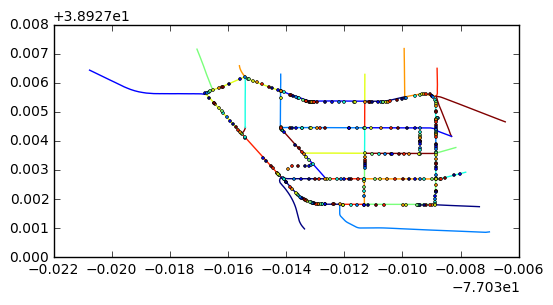

In [90]:
orgn_pts = gp.read_file('test_pts2segs5.geojson')
tss = [time.strftime('%Y-%m-%dT%H:%M:%SZ',time.gmtime(t+i*5)) for i in range(orgn_pts.shape[0])]

return_confidence=True
pts_lon_lat = list(orgn_pts.geometry.apply(lambda x: x.coords[0]).values)

snap_pts = snap2road(pts_lon_lat,tss, return_confidence=return_confidence)

if return_confidence:  # if return_confidence
    snap_pts, confs = snap_pts   
    
snap_pts_gpdf = gp.GeoDataFrame([Point(x) for x in snap_pts],columns=['geometry'])
print confs

pts_segs, pts_no_segs = pts2segs(snap_pts_gpdf, segs_dc, bfr_crs=3559, close_jn_dist=10, far_jn_dist=30)

snap_pts_gpdf = snap_pts_gpdf.merge(
    snap_pts_gpdf.merge(pts_segs, left_index=True, right_on='index_pt').groupby('index_pt')['index_ln'].apply(list).to_frame(), 
    left_index=True, right_index=True, how='left')

for row in snap_pts_gpdf.loc[snap_pts_gpdf.index_ln.isnull(), 'index_ln'].index:
    snap_pts_gpdf.at[row, 'index_ln'] = []

segs_dc.loc[pts_segs.index_ln.value_counts().index.tolist()][['geometry']].append(snap_pts_gpdf).plot()

In [91]:
snap_pts_gpdf['clean_seg']=seg_disambiguation(snap_pts_gpdf.index_ln.values,keep_tie=True)
snap_pts_gpdf['clean_seg2']=seg_disambiguation(snap_pts_gpdf.clean_seg.values)
show_grid(pd.DataFrame(snap_pts_gpdf.iloc[:,1:]))

In [92]:
# linear reference for each segs
from itertools import chain
trace_segs = pd.unique(chain(*snap_pts_gpdf.clean_seg2.values))
print len(trace_segs)
for seg_index in trace_segs:
    seg = segs_dc.loc[seg_index,'geometry']
    projected = snap_pts_gpdf[snap_pts_gpdf.index_ln.apply(lambda x: seg_index in x)].geometry.apply(lambda x: seg.project(x,normalized=True))
    s, e = projected.min(), projected.max()
    round_s, round_e = float_round(s, direction='down'), float_round(e, direction='up')
    print (seg_index, round_s, round_e, round_e - round_s)

25
(2431, 0.0, 1.0, 1.0)
(2432, 0.0, 1.0, 1.0)
(2025, 0.0, 1.0, 1.0)
(2026, 0.0, 1.0, 1.0)
(2190, 0.0, 1.0, 1.0)
(5257, 0.0, 1.0, 1.0)
(5084, 0.0, 1.0, 1.0)
(5083, 0.0, 1.0, 1.0)
(5082, 0.0, 1.0, 1.0)
(935, 0.0, 1.0, 1.0)
(934, 0.0, 1.0, 1.0)
(933, 0.0, 1.0, 1.0)
(932, 0.0, 1.0, 1.0)
(2430, 0.0, 1.0, 1.0)
(1126, 0.0, 1.0, 1.0)
(2133, 0.0, 1.0, 1.0)
(2134, 0.0, 1.0, 1.0)
(1175, 0.0, 1.0, 1.0)
(1050, 0.0, 1.0, 1.0)
(2385, 0.0, 1.0, 1.0)
(2384, 0.0, 1.0, 1.0)
(2136, 0.0, 1.0, 1.0)
(1127, 0.0, 1.0, 1.0)
(2132, 0.0, 1.0, 1.0)
(2131, 0.1, 1.0, 0.9)


In [94]:
import numpy as np
np.where(np.diff(a) != 1)

(array([0, 4], dtype=int64),)

[(-77.0388715736476, 38.928806727412685), (-77.03886989595551, 38.928901225178365), (-77.0388637220345, 38.92925388748542), (-77.03886038897325, 38.929444249439996), (-77.0388571384783, 38.929616849783834), (-77.03885590485244, 38.929681079459), (-77.0388555666682, 38.92969540278752)]
173    1.000000
174    0.998517
175    0.991742
176    0.754312
177    0.529264
178    0.525870
179    0.492122
180    0.350324
181    0.208545
182    0.097120
183    0.021751
184    0.000000
301    0.991742
Name: geometry, dtype: float64
173    1.000000
174    0.998517
175    0.991742
176    0.754312
177    0.529264
178    0.525870
179    0.492122
180    0.350324
181    0.208545
182    0.097120
183    0.021751
184    0.000000
Name: geometry, dtype: float64
(932, 0.0, 1.0) (0.0, 1.0)
301    0.991742
Name: geometry, dtype: float64


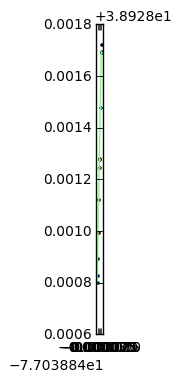

In [111]:
# pick one seg to check the projection
seg_index = 932
print segs_dc.loc[seg_index,'geometry'].coords[:]
snap_pts_gpdf[snap_pts_gpdf.index_ln.apply(lambda x: seg_index in x)].append(segs_dc.loc[seg_index,['geometry']]).plot()

seg = segs_dc.loc[seg_index,'geometry']
projected = snap_pts_gpdf[snap_pts_gpdf.index_ln.apply(lambda x: seg_index in x)].geometry.apply(lambda x: seg.project(x,normalized=True))
print projected
for sub_indices in consecutive(projected.index.values):
    sub = projected[sub_indices]
    print sub
    s, e = sub.min(), sub.max()
    round_s, round_e = float_round(s, direction='down'), float_round(e, direction='up')
    if e-s>0.05:
        print (seg_index, round_s, round_e), (s,e)

In [96]:
# visualize the trace and corresponding segments
part_segs_dc_plt= segs_dc.loc[pts_segs.index_ln.value_counts().index.tolist()][['geometry']].reset_index()
part_segs_dc_plt['color']='#0a0'

snap_line = gp.GeoDataFrame([LineString(snap_pts_gpdf.geometry.tolist())], columns=['geometry'])
snap_line['color'] = '#aa0'

snap_pts_gpdf_plt = snap_pts_gpdf.reset_index()
snap_pts_gpdf_plt['wkt'] = snap_pts_gpdf_plt.geometry.apply(lambda x: x.wkt)
snap_pts_gpdf_plt.index_ln = snap_pts_gpdf_plt.index_ln.apply(str)
snap_pts_gpdf_plt.clean_seg = snap_pts_gpdf_plt.clean_seg.apply(str)
snap_pts_gpdf_plt.clean_seg2 = snap_pts_gpdf_plt.clean_seg2.apply(str)
snap_pts_gpdf_plt.geometry = snap_pts_gpdf_plt.buffer(0.00002)
snap_pts_gpdf_plt['color'] = '#a00'

orgn_pts_plt = orgn_pts.reset_index()
orgn_pts_plt['wkt'] = orgn_pts_plt.geometry.apply(lambda x: x.wkt)
orgn_pts_plt.geometry = orgn_pts_plt.buffer(0.00002)
orgn_pts_plt['color'] = '#00a'

from leaflet_creation import create_map_visualization

html_title = 'openstreetmap elements'
file_path = ''
file_name = 'vis snap2segs'
lon, lat = -77.0908494, 38.9045525  #D.C.
zoom = 12
init_layers = ['streets', 'stsg']
map_layers = ['light','streets', 'satellite']
binding_data=[['ly1','snap'],['ly2','orgn'],['ly3', 'segments'],['ly4','snap line']]
gpdfs = [snap_pts_gpdf_plt, orgn_pts_plt, part_segs_dc_plt, snap_line]
create_map_visualization(html_title, file_path, file_name, lat, lon, zoom, init_layers, map_layers, binding_data, gpdfs)